# Machine Learning with Swift for TensorFlow and SwiftPlot

## Introduction

In this tutorial, we'll take a look at using Swift for TensorFlow in conjunction with SwiftPlot to build a machine learning model and visualize the resulting data in the `swift-jupyter` environment.

### Swift for TensorFlow

With Tensorflow's Python API experiencing performance limitations and lacking features, Swift for TensorFlow began development as a next-generation platform for machine learning, incorporating the latest research across machine learning, compilers, differentiable programming, systems design, and beyond. Read more about it on its [website](https://www.tensorflow.org/swift) and see the source code on [GitHub](https://github.com/tensorflow/swift).

### SwiftPlot

The SwiftPlot framework is a cross-platform library that lets you plot data natively in Swift. It started as a GSoC 2019 project with TensorFlow and is continuing active development with GCI 2019. Read more and see the source code on [GitHub](https://github.com/KarthikRIyer/swiftplot).

### Significance

Previously, Swift for Tensorflow projects needed to fallback to Python libraries such as `matplotlib` and `numpy` for data analysis and visualization. However, as more and more features fallback to Python, this results in these projects taking on some (not all) of the previous performance limitations and issues of Python discussed earlier.

This tutorial aims to create the first project to build, train, analyze, and visualize a machine learning model all natively in Swift, with no Python fallback. Hopefully, this will be a step forward towards the goal of having S4TF machine learning researchers using pure Swift in the future.


## Setting Up the Environment

Setting up S4TF and SwiftPlot does take some time, but with a little work we should get there without much trouble. For the purposes of our tutorial, we will set both up in the `swift-jupyter` environment with Ubuntu 18.04. Please note that currently, Google Colab is not supported.

First, let's clone the `swift-jupyter` repo. Use `git clone` to clone `https://github.com/google/swift-jupyter.git`

S4TF and SwiftPlot both requires some dependencies. Use `sudo apt install` to install `python3`, `python3-venv`, `libfreetype6-dev`, `openssl`, and `libssl-dev`. We'll install the rest of what we need for this project later in our `swift-jupyter` environment. Note that `python3` and `python3-venv` are only for the setup of the `swift-jupyter` environment. Our project will not need to `import Python`.

Next, navigate [here](https://github.com/tensorflow/swift/blob/master/Installation.md) to download and extract the S4TF toolchain. For our tutorial, we chose the Ubuntu 18.04 (CPU Only) release v0.6.0 from Dec 10, 2019.

Create a virtualenv, install the requirements and register the kernel with the following:
```
python3 -m venv venv
. venv/bin/activate
pip install -r requirements.txt
python register.py --sys-prefix --swift-toolchain <path to extracted swift toolchain directory>
```
We then can run Jupyter with:
```
. venv/bin/activate
jupyter notebook
```

Once we're in Jupyter, we can create a new notebook and install SwiftPlot along with `Datasets` from `tensorflow/swift-models`.

In [1]:
%install-swiftpm-flags -Xcc -isystem/usr/include/freetype2 -Xswiftc -lfreetype
%install '.package(url: "https://github.com/IBM-Swift/BlueCryptor.git", from: "1.0.28")' Cryptor
%install '.package(url: "https://github.com/KarthikRIyer/swiftplot", .branch("master"))' SwiftPlot AGGRenderer

%install '.package(url: "https://github.com/tensorflow/swift-models", .branch("tensorflow-0.6"))' Datasets

Installing packages:
	.package(url: "https://github.com/IBM-Swift/BlueCryptor.git", from: "1.0.28")
		Cryptor
	.package(url: "https://github.com/KarthikRIyer/swiftplot", .branch("master"))
		SwiftPlot
		AGGRenderer
	.package(url: "https://github.com/tensorflow/swift-models", .branch("tensorflow-0.6"))
		Datasets
With SwiftPM flags: ['-Xcc', '-isystem/usr/include/freetype2', '-Xswiftc', '-lfreetype']
Working in: /tmp/tmpxkwuwi5d/swift-install
Fetching https://github.com/KarthikRIyer/swiftplot
Fetching https://github.com/tensorflow/swift-models
Fetching https://github.com/IBM-Swift/BlueCryptor.git
Fetching https://github.com/IBM-Swift/OpenSSL.git
Cloning https://github.com/IBM-Swift/OpenSSL.git
Resolving https://github.com/IBM-Swift/OpenSSL.git at 2.2.2
Cloning https://github.com/tensorflow/swift-models
Resolving https://github.com/tensorflow/swift-models at tensorflow-0.6
Cloning https://github.com/IBM-Swift/BlueCryptor.git
Resolving https://github.com/IBM-Swift/BlueCryptor.git at 1.0.3

We can enable the generated plot display in the notebook with:

In [2]:
%include "EnableJupyterDisplay.swift"

Finally, we'll configure all of the necessary imports.

In [3]:
import TensorFlow
import Datasets

import SwiftPlot
import AGGRenderer

//No Python import! :D

## Initializing the Dataset

For our tutorial, we'll be using the MNIST dataset with a batch size of 500. There are 60,000 images in training and 10,000 in testing, both of which should divide into 500 very nicely.

In [4]:
let batchSize = 500
let mnist = MNIST(batchSize: batchSize)

Loading resource: train-images-idx3-ubyte
Loading local data at: /home/wzhang/Documents/GCI/swift-jupyter/train-images-idx3-ubyte
Succesfully loaded resource: train-images-idx3-ubyte
Loading resource: train-labels-idx1-ubyte
Loading local data at: /home/wzhang/Documents/GCI/swift-jupyter/train-labels-idx1-ubyte
Succesfully loaded resource: train-labels-idx1-ubyte
Loading resource: t10k-images-idx3-ubyte
Loading local data at: /home/wzhang/Documents/GCI/swift-jupyter/t10k-images-idx3-ubyte
Succesfully loaded resource: t10k-images-idx3-ubyte
Loading resource: t10k-labels-idx1-ubyte
Loading local data at: /home/wzhang/Documents/GCI/swift-jupyter/t10k-labels-idx1-ubyte
Succesfully loaded resource: t10k-labels-idx1-ubyte


## Building the Model

Next, let's build a very simple model.

First, we define a simple struct, `Model`, that conforms to the `Layer` protocol. This model will take in the input image and return the class output.

We'll use one `Flatten<Float>` layer with hidden and output `Dense<Float>` layers. Feel free to play around with different sizes, layers, etc. to see how the model would change. Note that the first input size must be set at `28 * 28` as the images provided in MNIST are of that size and the last output size must be set to `10` since those are the number of classes in MNIST. Also, the `outputSize` of `hidden` and `inputSize` of `output` should be the same.

The `Layer` protocol requires a function, `callAsFunction`, that is called to pass the `input` through our model.

In [5]:
struct Model: Layer {
    var flatten = Flatten<Float>()
    var hidden = Dense<Float>(inputSize: 28 * 28, outputSize: 20, activation: relu)
    var output = Dense<Float>(inputSize: 20, outputSize: 10, activation: softmax)
    
    @differentiable
    func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
        return input.sequenced(through: flatten, hidden, output)
    }
}

Lastly, we can initialize an instance with:

In [6]:
var model = Model()

## Training the Model

In order to train the model, we'll have to determine the number of epochs our model trains for. This will be the number of times our model will "pass through" the entire dataset. For our example, we'll set this number equal to 10.

In [7]:
let numEpochs = 10

We also need an optimizer. This will "shape" our model as we train it. Let's use the Adam optimizer, which is an adaptive learning rate optimization algorithm derived from adaptive moment estimation.

In [8]:
let optimizer = Adam(for: model)

### Benchmarking

We can create a basic `struct` to hold and update some data while training.

In [9]:
struct Stat {
    var correct: Int = 0
    var loss: Float = 0
    mutating func update(logits: Tensor<Float>, labels: Tensor<Int32>) {
        self.correct += Int(Tensor<Int32>(logits.argmax(squeezingAxis: 1) .== labels).sum().scalarized())
    }
}

We'll also create some arrays to hold some values for after training in order to visualize them with SwiftPlot.

In [10]:
var epochs: [Float] = Array(stride(from: Float(1), to: Float(numEpochs+1), by: Float(1)))
var trainLoss: [Float] = []
var trainAccuracy: [Float] = []
var testLoss: [Float] = []
var testAccuracy: [Float] = []

Next, we can start the training model loop.

In [11]:
//training loop
for epoch in epochs {
    //training phase
    var trainStat = Stat()
    Context.local.learningPhase = .training
    for i in 0 ..< mnist.trainingSize / batchSize {
        //get batch of images/labels
        let images = mnist.trainingImages.minibatch(at: i, batchSize: batchSize)
        let labels = mnist.trainingLabels.minibatch(at: i, batchSize: batchSize)
        //compute gradient
        let(loss, gradients) = valueWithGradient(at: model) {model -> Tensor<Float> in
            let logits = model(images)
            trainStat.update(logits: logits, labels: labels)
            return softmaxCrossEntropy(logits: logits, labels: labels)
        }
        trainStat.loss += loss.scalarized()
        //update model
        optimizer.update(&model, along: gradients)
    }
    
    //inference phase
    var testStat = Stat()
    Context.local.learningPhase = .training
    for i in 0 ..< mnist.testSize / batchSize {
        //get batch of images/labels
        let images = mnist.testImages.minibatch(at: i, batchSize: batchSize)
        let labels = mnist.testLabels.minibatch(at: i, batchSize: batchSize)
        //compute loss
        let logits = model(images)
        testStat.update(logits: logits, labels: labels)
        let loss = softmaxCrossEntropy(logits: logits, labels: labels)
        testStat.loss += loss.scalarized()
    }
    
    //calculate and store data
    trainLoss.append(trainStat.loss)
    trainAccuracy.append(Float(trainStat.correct)/Float(60000))
    testLoss.append(testStat.loss)
    testAccuracy.append(Float(testStat.correct)/Float(10000))
    
    //print data
    print("Epoch: \(Int(epoch))")
    print("Train Loss: \(trainLoss[Int(epoch)-1])")
    print("Train Accuracy: \(trainAccuracy[Int(epoch)-1])")
    print("Test Loss: \(testLoss[Int(epoch)-1])")
    print("Test Accuracy: \(testAccuracy[Int(epoch)-1])")
    print("\n")
}

Epoch: 1
Train Loss: 235.82281
Train Accuracy: 0.60066664
Test Loss: 33.893257
Test Accuracy: 0.84


Epoch: 2
Train Loss: 197.53268
Train Accuracy: 0.86516666
Test Loss: 32.067234
Test Accuracy: 0.8912


Epoch: 3
Train Loss: 191.28587
Train Accuracy: 0.89706665
Test Loss: 31.534693
Test Accuracy: 0.9065


Epoch: 4
Train Loss: 188.8944
Train Accuracy: 0.9083833
Test Loss: 31.27526
Test Accuracy: 0.9152


Epoch: 5
Train Loss: 187.5354
Train Accuracy: 0.91583335
Test Loss: 31.113277
Test Accuracy: 0.9197


Epoch: 6
Train Loss: 186.60721
Train Accuracy: 0.92075
Test Loss: 30.999044
Test Accuracy: 0.9228


Epoch: 7
Train Loss: 185.90916
Train Accuracy: 0.92476666
Test Loss: 30.913149
Test Accuracy: 0.9251


Epoch: 8
Train Loss: 185.34755
Train Accuracy: 0.9285667
Test Loss: 30.843664
Test Accuracy: 0.9281


Epoch: 9
Train Loss: 184.88115
Train Accuracy: 0.9314
Test Loss: 30.787144
Test Accuracy: 0.9308


Epoch: 10
Train Loss: 184.48714
Train Accuracy: 0.9342667
Test Loss: 30.738052
Test Acc

## Visualizing the Data

Now, let's visualize our data with SwiftPlot! As demonstrated below, SwiftPlot is very flexible, easy, and intuitive to use.

From our arrays, we've gathered the following data:

In [12]:
print("Train Loss: \(trainLoss)")
print("Train Accuracy: \(trainAccuracy)")
print("Test Loss: \(testLoss)")
print("Test Accuracy: \(testAccuracy)")

Train Loss: [235.82281, 197.53268, 191.28587, 188.8944, 187.5354, 186.60721, 185.90916, 185.34755, 184.88115, 184.48714]
Train Accuracy: [0.60066664, 0.86516666, 0.89706665, 0.9083833, 0.91583335, 0.92075, 0.92476666, 0.9285667, 0.9314, 0.9342667]
Test Loss: [33.893257, 32.067234, 31.534693, 31.27526, 31.113277, 30.999044, 30.913149, 30.843664, 30.787144, 30.738052]
Test Accuracy: [0.84, 0.8912, 0.9065, 0.9152, 0.9197, 0.9228, 0.9251, 0.9281, 0.9308, 0.9324]


First, we'll have to define our renderer. For `swift-jupyter`, this will be of the type `AGGRenderer()`.

In [13]:
var agg_renderer: AGGRenderer = AGGRenderer()

Next, we'll make a `LineGraph` and use `addSeries` to add the accuracy arrays that we just made in the training step.

In [14]:
var accuracyGraph = LineGraph<Float,Float>(enablePrimaryAxisGrid: true)
accuracyGraph.addSeries(epochs, trainAccuracy, label: "Train", color: .orange)
accuracyGraph.addSeries(epochs, testAccuracy, label: "Test", color: .lightBlue)

We can then configure things such as the title, axes labels, and line settings as such:

In [15]:
accuracyGraph.plotTitle.title = "Accuracy"
accuracyGraph.plotLabel.xLabel = "EPOCH"
accuracyGraph.plotLabel.yLabel = "SCORE"
accuracyGraph.plotLineThickness = 3.0

Finally, we can display the graph in the notebook as a PNG as follows:

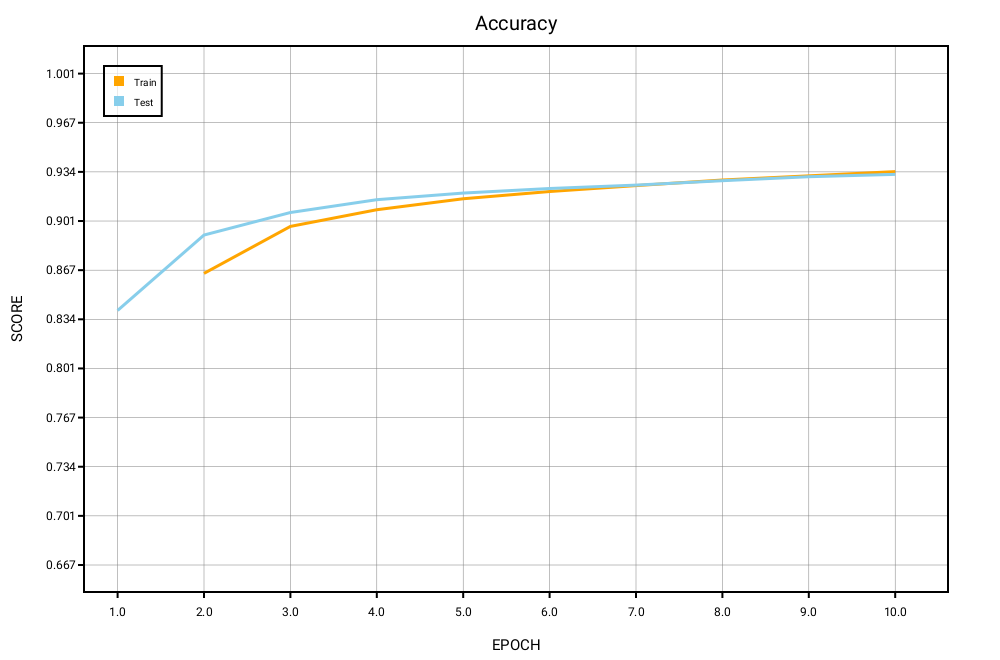

In [16]:
accuracyGraph.drawGraph(renderer: agg_renderer)
display(base64EncodedPNG: agg_renderer.base64Png())

From this, we can see that at first, both accuracies started out relatively low, but after each epoch they improved in an inverse exponential pattern. Although the test accuracy was better at first, at around epoch 5 it began to level off while the train accuracy still continued to increase for a bit.

We can do that similarly for the losses as well:

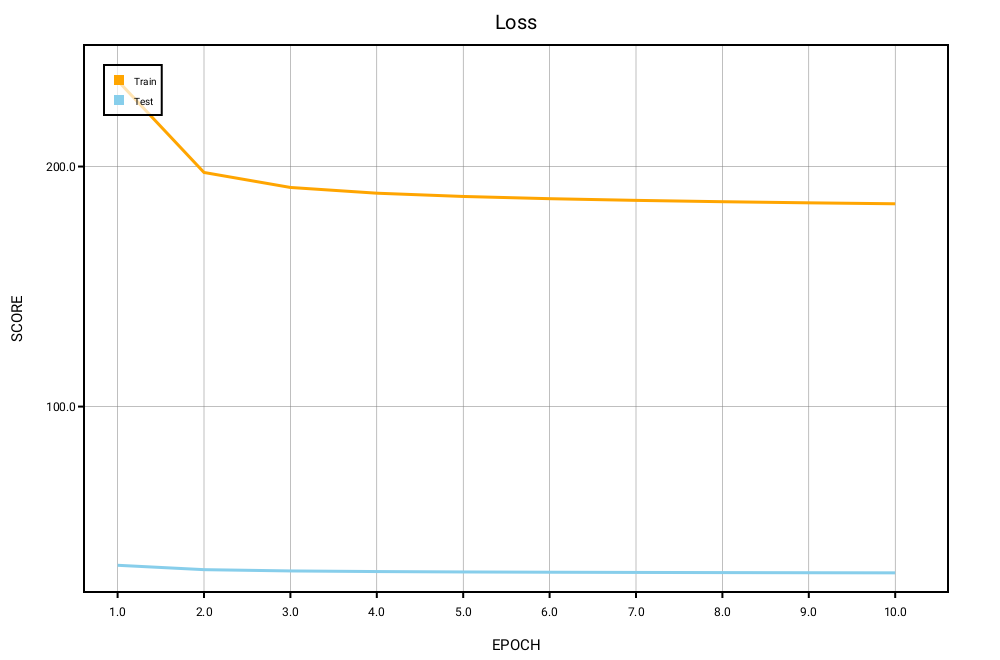

In [17]:
var lossGraph = LineGraph<Float,Float>(enablePrimaryAxisGrid: true)

lossGraph.addSeries(epochs, trainLoss, label: "Train", color: .orange)
lossGraph.addSeries(epochs, testLoss, label: "Test", color: .lightBlue)
lossGraph.plotTitle.title = "Loss"
lossGraph.plotLabel.xLabel = "EPOCH"
lossGraph.plotLabel.yLabel = "SCORE"
lossGraph.plotLineThickness = 3.0

lossGraph.drawGraph(renderer: agg_renderer)
display(base64EncodedPNG: agg_renderer.base64Png())

Note that because the test loss remained virtually unchanged. This is due to the fact that there are significantly less images in test than train, so the test loss didn't have the opportunity to improve as much as the train split.

We can then combine these two into one displayable data object by using `SubPlot`.

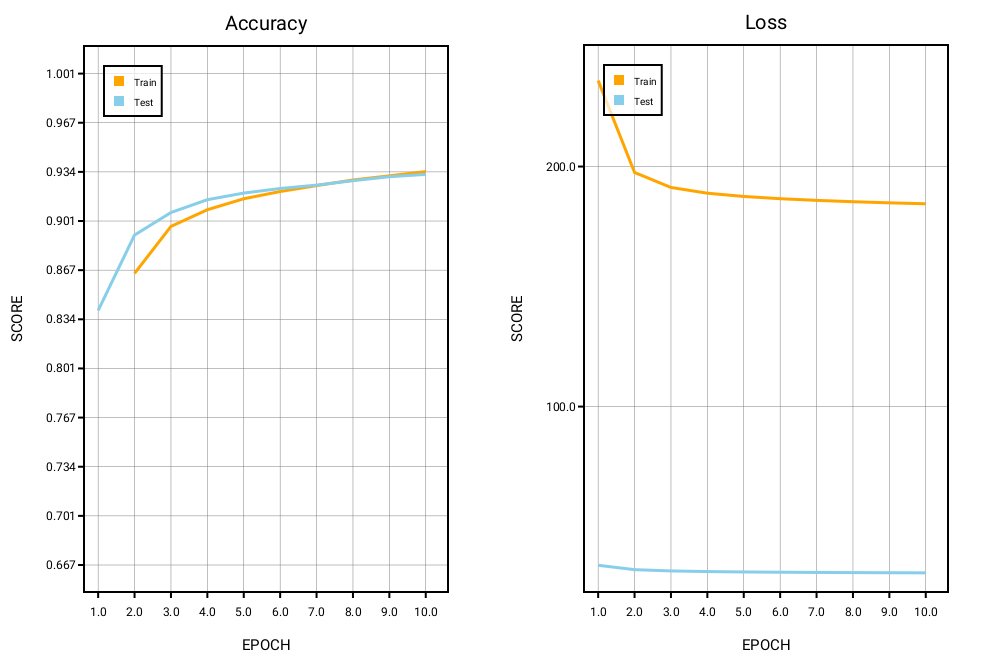

In [18]:
var subplot = SubPlot(layout: .horizontal)
subplot.plots = [accuracyGraph, lossGraph]

subplot.drawGraph(renderer: agg_renderer)
display(base64EncodedPNG: agg_renderer.base64Png())

## TroubleShooting

Don't be sad if you run into some difficulty with this tutorial, these are some new developments in machine learning and there's bound to be some hiccups along the way :)

### Swift for TensorFlow

If you're having trouble installing/running Swift for TensorFlow, please join the [Google Group](https://groups.google.com/a/tensorflow.org/forum/#!forum/swift) and ask for help! Be as detailed as possible, and nice people will help you find a solution.

### SwiftPlot

If you're having trouble installing/running SwiftPlot, please go to [GitHub Issues](https://github.com/KarthikRIyer/swiftplot/issues) and file an issue! We'll be happy to help you work out any problems you might be facing.

## Conclusion

And we're done! We successfully built, trained, analyzed, and visualized a machine learning model all natively in Swift!

This project was only a step in the right direction to pure Swift machine learning development, as Swift for TensorFlow as well as SwiftPlot are still in early stage active development, with programmers working hard to add to new features, fix bugs, and improve usability. 

Hopefully, through this tutorial it can be seen that Swift for TensorFlow and open source Swift libraries are a real contender for the future of machine learning, and it's entirely possible now to create complete (albeit simple) projects without the need for any Python fallback :P

This is a very significant acheivement as now it shows that perhaps as development for Swift for TensorFlow and other Swift libraries such as SwiftPlot continues, Swift machine learning researchers won't have to worry about any Python specifics such as `numpy` arrays, `PythonObject`s, `import Python`, `Python.import()`, etc.

## Credits/Acknowledgments

This tutorial wouldn't be possible without the previous hard work of other people. Big thank-you's to the following:

- Swift for TensorFlow team
- SwiftPlot contributors
- Karthik Iyer and Ayush Agrawal for their support and guidance

### References

Here are some references that I found helpful while working on this tutorial:

- [S4TF Tutorial (Wierenga)](https://rickwierenga.com/blog/s4tf/s4tf-mnist.html)
- [S4TF Tutorial (Bolella)](https://heartbeat.fritz.ai/swifty-ml-an-intro-to-swift-for-tensorflow-9edc7045bc0c)
- [Swift for TensorFlow Github](https://github.com/tensorflow/swift)
- [Swift for TensorFlow Documentation](https://www.tensorflow.org/swift)
- [SwiftPlot Github](https://github.com/KarthikRIyer/swiftplot)


Thanks for reading, and have fun playing around with Swift for TensorFlow and SwiftPlot!

Written By: William Zhang